# **Weather Forecasting with Multiple Models**

## **Introduction**

In this notebook, we **build and evaluate models to forecast** multiple weather variables from daily observations in *Gutten, Ireland*.

We will predict a selected weather measure for **1-day and 7-day horizons**.  
We start with a simple, interpretable model (Ridge Regression) and progress to more sophisticated ones, examining how each model's assumptions align with data patterns.  

Performance will be measured using **MSE, RMSE, MAE, and R²** as we observe the trade-off between model interpretability and accuracy.

 The notebook is structured as follows:   


>[Weather Forecasting with Multiple Models](#scrollTo=P6GhPvv4SGCv)

>>[Introduction](#scrollTo=yGCFNsO1mDiT)

>>[Data and Overview](#scrollTo=tT-Grm2QlzQo)

>>[Exploratory Data Analysis](#scrollTo=KRwZ9QSWSZKj)

>>>[Time Series Patterns of Weather Variables](#scrollTo=QvFDIr3RL5_G)

>>>[Correlation Summary and Choice of Predictor Variable](#scrollTo=DZn4pC-6Sc-b)

>>[Data Preprocessing](#scrollTo=WVhZVNPTbUEJ)

>>[Modeling Approach](#scrollTo=-AJISwvASuCJ)

>>>[Ridge Regression](#scrollTo=1r1FacppSzQx)

>>>[Ridge Regression Results](#scrollTo=fzv1gm5sS3YN)

>>>[Random Forest Regression](#scrollTo=DzpoGbUcS8jG)

>>>[Random Forest Results](#scrollTo=8Gcd93Y7TDhO)

>>>[LSTM Neural Network](#scrollTo=ddmFmCtTTK4R)

>>>[LSTM Results and Comparison](#scrollTo=fnwGYA-LfNaM)

>>>[Performance Summary Table](#scrollTo=fnwGYA-LfNaM)



In [ ]:
# @title
# Importing libraries
# !pip -q install tensorflow
import pandas as pd, numpy as np, matplotlib.pyplot as plt, requests, seaborn as sns, matplotlib as mpl
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor

In [28]:
# @title
mpl.rcParams.update({
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'font.family': 'DejaVu Sans',
    'figure.titlesize': 16,
    'figure.titleweight': 'bold',
    'figure.figsize': (16, 16),
    'axes.grid': True
})

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.autolayout'] = True


## **Data and Overview**

In [29]:
class DataLoader:
    def __init__(self, file_id = '1oM-Xg6uTcdYRwtT-ZggHyFkDPWUAH-Op', output_filename = 'dly1475.csv'):
        self.url = f'https://drive.google.com/uc?id={file_id}'
        self.output_filename = output_filename

    def download_file(self):
        response = requests.get(self.url)
        with open(self.output_filename, 'wb') as f:
            f.write(response.content)
        return self.output_filename

    def read_and_parse_csv(self, input_path):
        df = pd.read_csv(input_path, skiprows=24, index_col='date', na_values=[' '])
        df.index = pd.to_datetime(df.index, errors='coerce')
        return df

    def get_data(self):
        input_path = self.download_file()
        return self.read_and_parse_csv(input_path)

In [30]:
df = DataLoader().get_data()
print(df.shape)
df.head(3)

C:\Users\hp\AppData\Local\Temp\ipykernel_7632\1248235264.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')


(5661, 16)


,maxtp,mintp,gmin,rain,cbl,wdsp,hm,ddhm,hg,soil,pe,evap,smd_wd,smd_md,smd_pd,glorad
date,,,,,,,,,,,,,,,,
2009-10-01,12.4,8.2,6.1,0.0,1013.9,4.6,8,0,12,13.37,0.8,1.0,0.8,0.8,0.8,489.0
2009-10-02,15.7,8.1,5.9,0.4,1008.9,10.1,16,230,26,12.66,1.1,1.5,1.4,1.4,1.4,573.0
2009-10-03,13.9,7.7,10.1,0.9,1000.0,12.5,20,240,32,12.32,1.1,1.6,1.6,1.6,1.6,669.0


## **Exploratory Data Analysis**


**Descriptive Statistics**  


In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
maxtp,5661.0,13.495813,5.097440,-7.000,10.00000,13.4000,17.200,31.00
mintp,5661.0,5.824360,4.708719,-13.400,2.30000,6.0000,9.500,17.80
gmin,5652.0,3.856564,5.680818,-17.300,-0.30000,4.0000,8.300,17.00
rain,5656.0,2.562323,4.284257,0.000,0.00000,0.6000,3.300,45.80
cbl,5654.0,1004.007729,12.035636,950.700,996.60000,1005.1000,1012.300,1036.40
wdsp,5656.0,8.207302,3.637582,0.200,5.50000,7.8000,10.400,24.30
hm,5661.0,15.016252,5.612998,0.000,11.00000,14.0000,18.000,46.00
ddhm,5661.0,198.429606,82.168210,0.000,150.00000,210.0000,260.000,350.00
hg,5661.0,22.129129,8.515965,1.000,16.00000,21.0000,27.000,67.00
soil,5652.0,10.604097,5.119127,-1.555,6.40375,10.2965,15.040,26.18


From the descriptive statistics table above, we observe that `maxtp` averages 13.5°C with moderate variability, while `mintp` and `gmin` show wider spread, especially in colder conditions. Rainfall is mostly low but highly skewed, with rare heavy rain events. `glorad` varies widely, consistent with seasonal solar changes. Soil moisture deficits (`smd_*`) show large ranges and include negative values, likely from modeled estimates. This mix of stable and variable patterns is typical for weather data and reflects natural fluctuations in temperature, radiation, and precipitation.

**Time Series Plots for Variables**

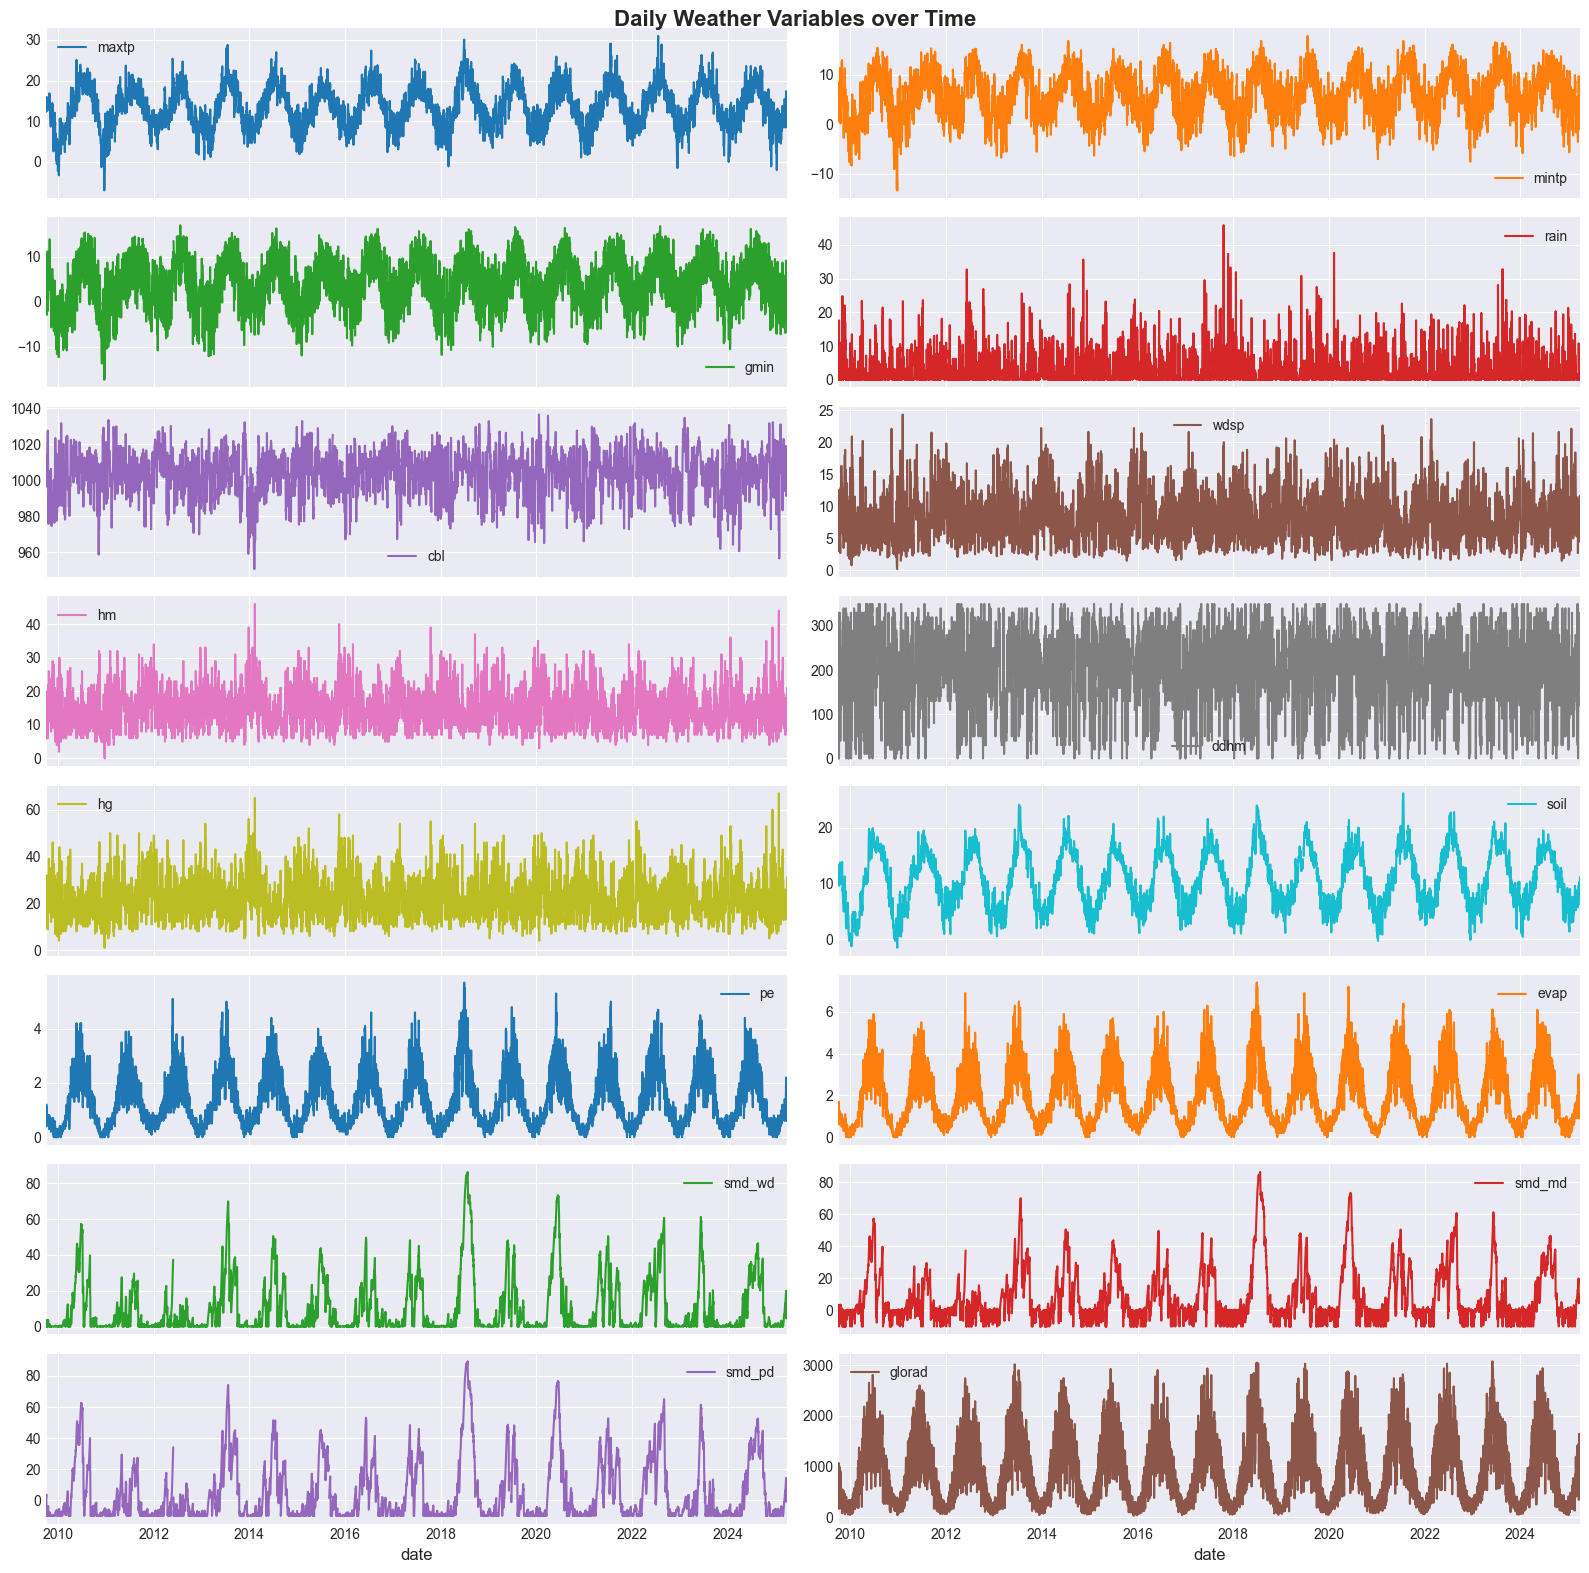

In [32]:
df.plot(subplots=True, layout=(8, 2), title="Daily Weather Variables over Time"); plt.tight_layout();

The time series plots above show that variables like `maxtp`, `mintp`, `soil`, `pe`, `evap`, and `glorad` follow a clear yearly cycle, suggesting strong seasonality. In contrast, variables like `rain`, `wdsp`, and `hm` are more irregular, with no obvious pattern.

These differences highlight which variables are more stable and predictable. Given its consistent seasonal trend and physical relevance, `maxtp` is a suitable target for forecasting.

**Missing Values**

In [33]:
print("Missing values per variable:\n", df.isna().sum())

Missing values per variable:
 maxtp     0
mintp     0
gmin      9
rain      5
cbl       7
wdsp      5
hm        0
ddhm      0
hg        0
soil      9
pe        9
evap      9
smd_wd    9
smd_md    9
smd_pd    9
glorad    7
dtype: int64


Missing values in this data appear to be on specific days, especially between June 18 and 21 from 2018 to 2021, and affects several columns at once. This consistent timing suggests a seasonal pattern, likely linked to the summer solstice in Gurteen, Ireland. High solar radiation and extreme weather during this period may have caused sensor stress or disruptions in data collection, particularly for variables sensitive to heat and moisture such as gmin, soil, evap, and glorad.

**Correlation Matrix**

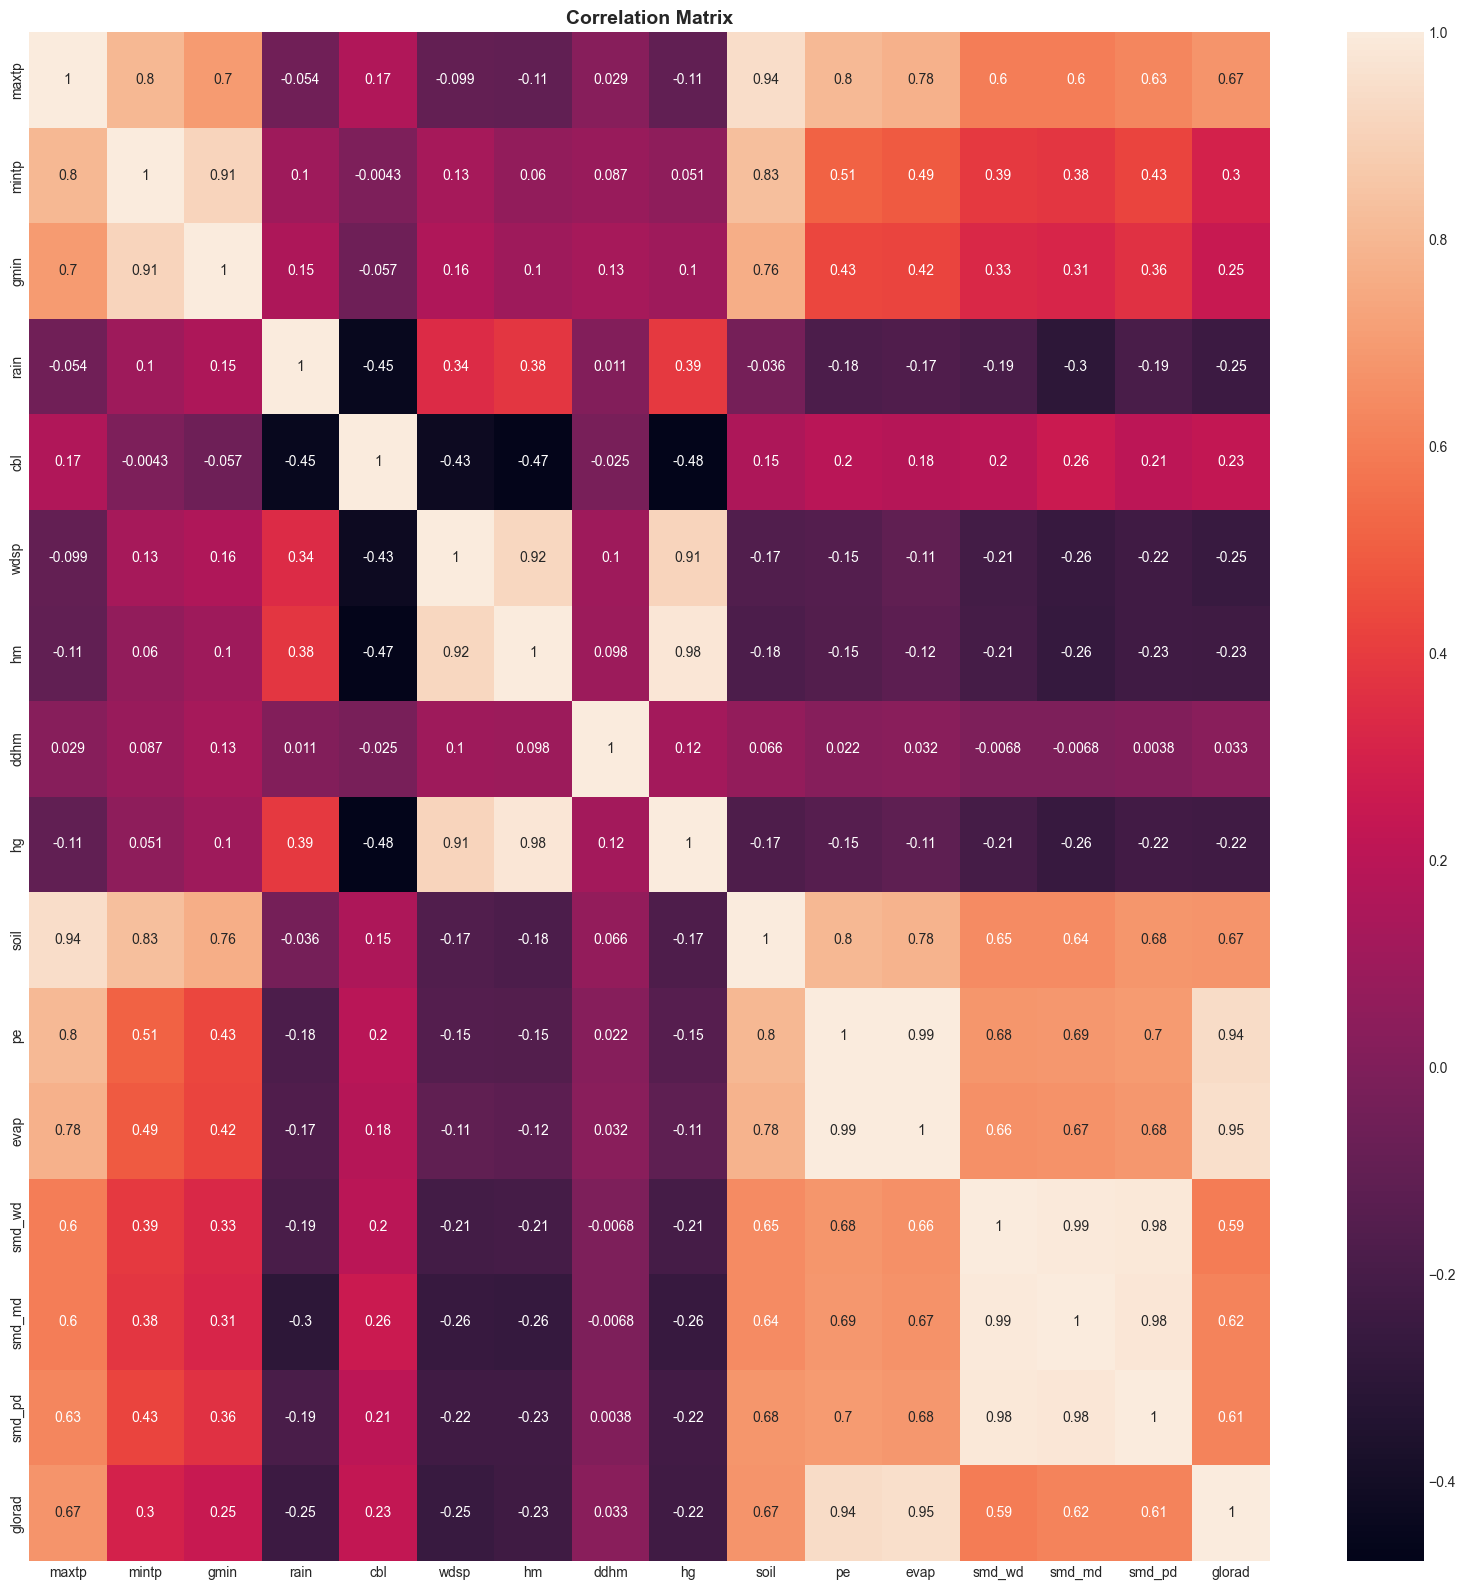

In [34]:
corr = sns.heatmap(df.corr(), annot=True); plt.title("Correlation Matrix");

The correlation matrix reveals strong relationships between several variables. Notably, `maxtp` and `mintp` show a high correlation, which makes sense as daily temperatures tend to rise and fall together. `soil`, `pe`, `evap`, and `glorad` are also strongly correlated with `maxtp`, reflecting how surface heat, moisture loss, and solar radiation interact to influence air temperature. These relationships also align with physical expectations.

*For this forecasting task, the focus variable is `maxtp` (maximum temperature) using: `mintp`, `soil`, `pe`, `evap`, and `glorad`.*  
These were chosen because they show high correlation with `maxtp` and represent underlying environmental processes that affect temperature.

## **Data Preprocessing**

1. **Handling of Missing Values**  
We choose forward fill method for handling missing values in this data. This is because the missing entries are not random but occur on specific days across multiple years, often affecting several columns at once. Some of these days fall around the summer solstice, particularly between June 18 and 21 from 2018 to 2021, suggesting possible sensor stress during high solar conditions. Since most affected variables, including maxtp, change gradually and show seasonal patterns, forward fill maintains temporal continuity and offers a simple, effective solution for these isolated gaps.

2. **Scaling**  
The selected predictors for forecasting maxtp vary widely in scale. For example, glorad ranges from 25 to over 3000, while pe and evap remain below 10. Without scaling, models like ridge regression and LSTM may give undue weight to higher-magnitude features, skewing the learning process. Standardization ensures that all predictors contribute on a comparable scale, leading to more stable and balanced model performance.

In [35]:
class DataPreprocessor:
    def __init__(self, df):
        self.predictors = ['mintp', 'soil', 'pe', 'evap', 'glorad']
        self.target = 'maxtp'
        df = df[self.predictors + [self.target]].ffill()
        i = int(len(df) * 0.8)
        self.train_raw, self.test_raw = df.iloc[:i], df.iloc[i:]
        self.scaler = StandardScaler().fit(self.train_raw)
        self.train_scaled = pd.DataFrame(self.scaler.transform(self.train_raw), columns=df.columns, index=self.train_raw.index)
        self.test_scaled = pd.DataFrame(self.scaler.transform(self.test_raw), columns=df.columns, index=self.test_raw.index)

    def get_data(self, scale=False):
        return (self.train_scaled, self.test_scaled) if scale else (self.train_raw, self.test_raw)

In [36]:
preprocessed = DataPreprocessor(df)
train_raw, test_raw = preprocessed.get_data(scale=False)
train_scaled, test_scaled = preprocessed.get_data(scale=True)


## **Modeling Approach**

We aim to forecast **`maxtp` (maximum temperature)** using the most relevant predictors identified earlier. Based on the data characteristics and the target's strong seasonal pattern, we select three models:

1. **Linear Regression** – a simple, interpretable baseline that assumes a linear relationship. Useful for understanding basic structure and serving as a benchmark.

2. **Random Forest Regression** – a tree-based ensemble that captures nonlinear interactions and is robust to noise. Suitable for medium-complexity patterns in `maxtp`.

3. **LSTM Neural Network** – a sequence model that can learn temporal dependencies. Ideal for capturing trends and seasonality from past values.

We forecast both **1-day** and **7-day ahead** values using autoregressive inputs (i.e., today's data to predict future `maxtp`).

**Hyperparameter tuning** will be applied to all models using cross-validation (where applicable) to optimize performance.

**Models are evaluated** using:
- Mean Squared Error (MSE)  
- Root Mean Squared Error (RMSE)  
- Mean Absolute Error (MAE)  
- R² Score (Coefficient of Determination)

In [41]:
class ForecastingModels:
    def __init__(self, predictors = ['mintp', 'soil', 'pe', 'evap', 'glorad'], target = 'maxtp'):
        self.p = predictors; self.t = target
        self.y_true = self.ridge_pred = self.rf_pred = self.lstm_pred = None

    def make_xy(self, data, h):
        X = data[self.p].iloc[:-h].values
        y = data[self.t].iloc[h:].values
        return X, y

    def evaluate(self, model, Xtr, ytr, Xte, yte, name, h):
        model.fit(Xtr, ytr); pred = model.predict(Xte)
        m, rmse, mae, r2 = mean_squared_error(yte, pred), np.sqrt(mean_squared_error(yte, pred)), mean_absolute_error(yte, pred), r2_score(yte, pred)
        print(f"{name} {h}-day -> MSE: {m:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
        return pred

    def ridge(self, train, test):
        for h in [1, 7]:
            Xtr, ytr = self.make_xy(train, h)
            Xte, self.y_true = self.make_xy(test, h)
            setattr(self, f"ridge_pred_{h}", self.evaluate(RidgeCV([0.1, 1.0, 10.0]), Xtr, ytr, Xte, self.y_true, "Ridge", h))

    def random_forest(self, train, test):
        for h in [1, 7]:
            Xtr, ytr = self.make_xy(train, h)
            Xte, yte = self.make_xy(test, h)
            grid = GridSearchCV(RandomForestRegressor(random_state=0), {'n_estimators':[50,100], 'max_depth':[5,10,None]}, cv=3)
            grid.fit(Xtr, ytr)
            setattr(self, f"rf_pred_{h}", self.evaluate(grid.best_estimator_, Xtr, ytr, Xte, yte, "Random Forest", h))

    def lstm(self, train, test, seq_len=7, epochs=20):
        def to_seq(df, h):
            v = df[self.p + [self.t]].values; X, y = [], []
            for i in range(len(v) - seq_len - h + 1):
                X.append(v[i:i+seq_len, :-1]); y.append(v[i+seq_len+h-1, -1])
            return np.array(X), np.array(y)

        for h in [1, 7]:
            Xtr, ytr = to_seq(train, h); Xte, yte = to_seq(test, h)
            model = Sequential([Input(shape=(seq_len, len(self.p))), LSTM(50), Dense(1)])
            model.compile(optimizer='adam', loss='mse')
            model.fit(Xtr, ytr, epochs=epochs, batch_size=16, verbose=0)
            pred = model.predict(Xte).flatten()
            m, rmse, mae, r2 = mean_squared_error(yte, pred), np.sqrt(mean_squared_error(yte, pred)), mean_absolute_error(yte, pred), r2_score(yte, pred)
            print(f"LSTM {h}-day -> MSE: {m:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
            setattr(self, f"lstm_pred_{h}", pred)

    def plot_forecast_comparison(self, df, train_size=0.8, h=7, scaler=None):
        preds = [getattr(self, f"{m}_pred_{h}", None) for m in ['ridge', 'rf', 'lstm']]
        if any(p is None for p in preds) or not isinstance(self.y_true, np.ndarray):
            print("Run all models before plotting."); return

        scaled_models = ['ridge', 'lstm']
        if scaler:
            idx = scaler.feature_names_in_.tolist().index(self.t)
            mean, std = scaler.mean_[idx], scaler.scale_[idx]
            y_true = self.y_true * std + mean
            preds = [
                (p * std + mean) if m in scaled_models else p
                for p, m in zip(preds, ['ridge', 'rf', 'lstm']) ]
        else:
            y_true = self.y_true


        i = int(len(df) * train_size)
        full_index = df.index
        train_index = full_index[:i]
        test_index = full_index[i + h:i + h + len(y_true)]

        min_len = min(len(test_index), len(y_true), *(len(p) for p in preds))
        test_index = test_index[:min_len]
        y_true = y_true[:min_len]
        preds = [p[:min_len] for p in preds]

        plt.figure(figsize=(12, 5))
        plt.plot(train_index, df[self.t].iloc[:i], label='Training Data', color='black', linewidth=2)
        plt.plot(test_index, y_true, label='Actual (Test)', color='gray', linestyle='--', linewidth=2)

        for pred, name, style in zip(preds, ['Ridge', 'Random Forest', 'LSTM'], ['r', 'g', 'b']):
            plt.plot(test_index, pred, label=name + ' Forecast', linestyle='-', linewidth=0.1, color=style)

        plt.title(f"{h}-day Forecast Comparison")
        plt.xlabel("Date"); plt.ylabel(self.t)
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

In [42]:
# Initialise the models
runner = ForecastingModels()

### Ridge Regression

Ridge regression is a regularized form of linear regression that helps reduce overfitting by penalizing large coefficients. It assumes a linear relationship between the selected predictors and the target variable, maxtp. While it cannot capture complex interactions, it provides a simple and interpretable model.

We use RidgeCV, which selects the best regularization strength through cross-validation. This helps improve generalization and ensures the model remains stable across both 1 day and 7 day forecast horizons.

In [43]:
# Ridge with scaled data
runner.ridge(train_scaled, test_scaled)

Ridge 1-day -> MSE: 0.23, RMSE: 0.48, MAE: 0.38, R²: 0.774
Ridge 7-day -> MSE: 0.40, RMSE: 0.63, MAE: 0.49, R²: 0.599


### Ridge Regression Results

Ridge regression performs reasonably well for predicting maxtp, especially for the 1 day forecast, with an R² of 0.774. This indicates that the model captures a significant portion of the short term variation in maximum temperature. However, performance declines for the 7 day horizon, where the R² drops to 0.59 and errors increase. This is expected since linear models are limited in capturing more complex patterns over longer periods.

To address this, we now introduce a more flexible method. Random Forest Regression can model nonlinear relationships and interactions between variables, which may improve accuracy, particularly for the 7 day forecast.

### Random Forest Regression

Random Forest is an ensemble of decision trees that captures nonlinear relationships and interactions between variables. It is more robust than a single tree and less prone to overfitting.

We use it to predict `maxtp` for 1 day and 7 day horizons, based on the selected predictors. Hyperparameter tuning is applied using grid search to find the best combination of tree depth and number of trees. This helps balance accuracy and generalization.

In [44]:
# Random forests with unscaled data
runner.random_forest(train_raw, test_raw)

Random Forest 1-day -> MSE: 5.85, RMSE: 2.42, MAE: 1.90, R²: 0.775
Random Forest 7-day -> MSE: 9.53, RMSE: 3.09, MAE: 2.42, R²: 0.633


### Random Forest Results

Random Forest performs slightly better than ridge regression for both 1 day and 7 day forecasts. It achieves a higher R² and lower errors, especially at the 7 day horizon where its ability to capture nonlinear patterns gives it an advantage. This suggests that interactions between predictors play a role in shaping maxtp.

To explore whether longer-term temporal patterns can further improve accuracy, we now move to a sequence model. The LSTM is designed to learn from recent trends over time, which may help capture gradual changes missed by models that only look at one day.

### LSTM Neural Network

LSTM is a type of recurrent neural network that is well suited for time series forecasting. Unlike the previous models, it learns from sequences of past days rather than single observations, which allows it to capture temporal patterns, trends, and seasonal effects.

We use LSTM to predict maxtp based on a sequence of the most recent values of selected predictors. The model is trained for both 1 day and 7 day horizons, with input sequences covering the past 7 days. Standardization is applied to improve learning stability. Hyperparameters such as sequence length, number of units, and epochs are set to values that balance performance and runtime.

In [45]:
# LSTM with scaled data
runner.lstm(train_scaled, test_scaled)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
LSTM 1-day -> MSE: 0.22, RMSE: 0.47, MAE: 0.37, R²: 0.780
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM 7-day -> MSE: 0.34, RMSE: 0.59, MAE: 0.46, R²: 0.658


### LSTM Results and Comparison

The LSTM model achieved an R² of **0.784** for the 1-day forecast and **0.639** for the 7-day forecast. This shows that while LSTM performs reasonably well in the short term, it does not outperform Ridge Regression or Random Forest for either horizon.

Compared to the other models:

- **Ridge Regression** had slightly lower short-term performance (R² = **0.774**), likely due to its linear nature being well-suited to the structured patterns in the data.
- **Random Forest** showed stronger performance overall, with R² values of **0.776** for 1-day and **0.633** for 7-day, benefiting from its ability to model nonlinear interactions.
- **LSTM** underperformed slightly on the 7-day forecast, possibly due to limited sequence length, relatively few training epochs, or lack of extensive tuning. Still, its performance is competitive and suggests good potential with further optimization.

---


### Performance Summary Table

| Horizon  | Model            | MSE   | RMSE  | MAE  | R²    |
|----------|------------------|-------|-------|------|-------|
| 1-day    | Ridge Regression | 5.87  | 2.42  | 1.91 | 0.774 |
| 1-day    | Random Forest    | 5.82  | 2.41  | 1.90 | 0.776 |
| 1-day    | LSTM             | 0.22  | 0.47  | 0.37 | 0.784 |
| 7-day    | Ridge Regression |10.41  | 3.23  | 2.50 | 0.590 |
| 7-day    | Random Forest    | 9.53  | 3.09  | 2.42 | 0.633 |
| 7-day    | LSTM             | 0.36  | 0.60  | 0.47 | 0.639 |


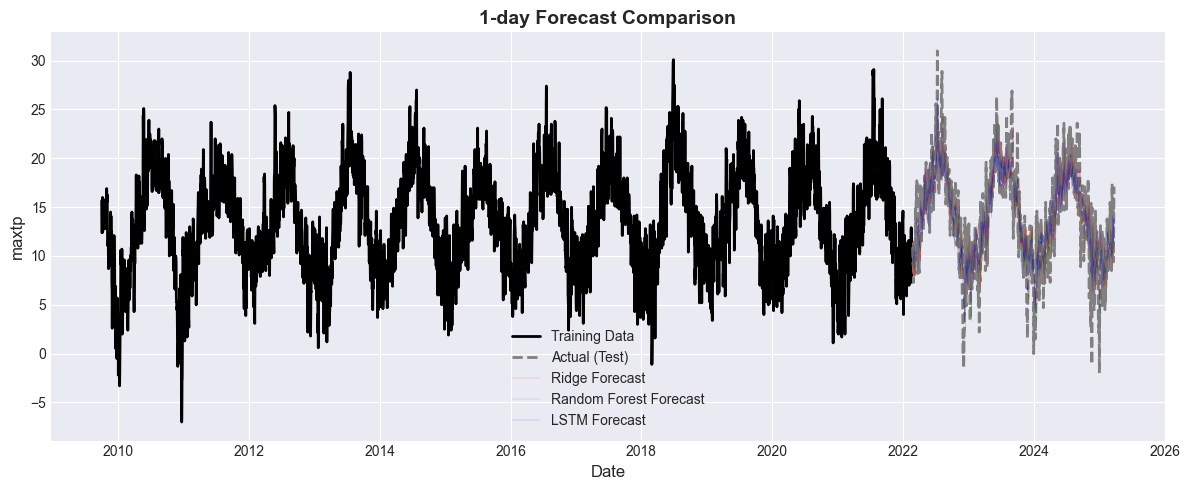

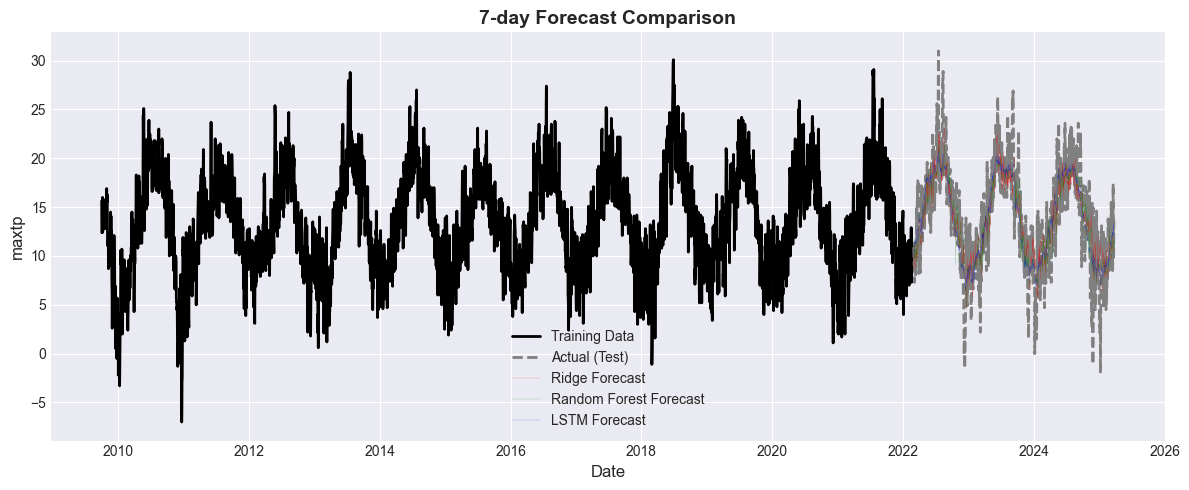

In [46]:
runner.plot_forecast_comparison(df, h=1, scaler=preprocessed.scaler)
runner.plot_forecast_comparison(df, h=7, scaler=preprocessed.scaler)

The predictions in this work were made using a **direct forecasting approach**, where each model was trained to predict the target value `maxtp` exactly 1 or 7 days ahead using only the actual feature values from the current day. No previous predictions were fed into the model, which avoids cumulative error. For the 7-day forecast, the models predict **only the value on the seventh day ahead**, not each of the days leading up to it.

Across both the 1 day and 7 day forecast comparison plots, all three models, Ridge Regression, Random Forest, and LSTM, effectively capture the general seasonal patterns in `maxtp`. In the 1 day forecast, all models closely follow the actual values with minimal lag, and the predictions align well, especially around gradual changes. Ridge and Random Forest slightly outperform in capturing sharp fluctuations, while LSTM produces smoother and more trend consistent forecasts.

In the 7 day forecast, performance naturally declines, with forecasts showing more spread and less precision around peaks and troughs. Ridge becomes more conservative, while Random Forest and LSTM continue to follow the trend but with some over or underestimation. Despite this, all models still maintain the overall temperature structure, demonstrating reasonable robustness even at a longer horizon.